In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#Imports 
import pandas as pd
import matplotlib.pyplot as plt, mpld3
import json
import datetime

from shapely.geometry import Polygon, mapping
import geopandas as gpd
import folium
from folium.plugins import TimeSliderChoropleth



In [4]:
us_shape = gpd.read_file('~/Downloads/States 21basic/geo_export_cdd5d0ec-6400-44e8-9db4-aeb812eadc08.shp')
us_shape = us_shape[['state_name','geometry']]
us_shape.head()


,state_name,geometry
0,Hawaii,"MULTIPOLYGON (((-160.07380 22.00418, -160.0497..."
1,Washington,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."
2,Montana,"POLYGON ((-111.47543 44.70216, -111.48080 44.6..."
3,Maine,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ..."
4,North Dakota,"POLYGON ((-98.73044 45.93827, -99.00683 45.939..."


In [5]:
#plot the shape file with folium 
m = folium.Map(location=[50.77500, -100],zoom_start=3) 
choropleth =folium.GeoJson(data= us_shape.to_json())
m.add_child(choropleth)

In [6]:
#Get election data
election = pd.read_csv("~/Downloads/1976-2016-president.csv" )
election.replace('democratic-farmer-labor','democrat',inplace=True)
election.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party,writein,candidatevotes,totalvotes,version,notes
0,1976,Alabama,AL,1,63,41,US President,"Carter, Jimmy",democrat,False,659170,1182850,20171015,NaN
1,1976,Alabama,AL,1,63,41,US President,"Ford, Gerald",republican,False,504070,1182850,20171015,NaN
2,1976,Alabama,AL,1,63,41,US President,"Maddox, Lester",american independent party,False,9198,1182850,20171015,NaN
3,1976,Alabama,AL,1,63,41,US President,"Bubar, Benjamin """"Ben""""",prohibition,False,6669,1182850,20171015,NaN
4,1976,Alabama,AL,1,63,41,US President,"Hall, Gus",communist party use,False,1954,1182850,20171015,NaN


In [7]:
# Transform election data 
states = set(election['state'])

results = {}
for year in range(1976,2020,4):
    
    result = {}
    for state in states:
        
        state_year = election[(election.year == year) 
                              & (election.state == state)]
        dem = max(state_year[state_year.party == 'democrat']['candidatevotes'])
        rep = max(state_year[state_year.party == 'republican']['candidatevotes'])
        
        result[state] = {'dem':dem, 'rep':rep}
        
    results[year] = result

In [8]:
def state_style(state,year,function=False):
    """
    Returns the style for a state in a given year
    """
    
    state_results = results[year][state]
    
    #Set state colour
    if state_results['dem'] >= state_results['rep']:
        color = '#E6E6FA'#lavender
    else:
        color = '#BDFCC9' #mint
    
    #Set state style
    if function == False:
        # Format for style_dictionary
        state_style = {
            'opacity': 1,
            'color': color,
        } 
    else:
        # Format for style_function
        state_style = {
             'fillOpacity': 1,
             'weight': 1,
             'fillColor': color,
             'color': '#000000'}    
  
    return state_style

In [9]:
def style_function(feature):
    """
    style_function used by the GeoJson folium function
    """

    state = feature['properties']['state_name']
    style = state_style(state,year=2016,function=True)
    
    return style

In [10]:
#plot the choropleth 
m = folium.Map(location=[50.77500, -100],zoom_start=3)
choropleth =folium.GeoJson(data= us_shape.to_json(),style_function=style_function)
m.add_child(choropleth)

In [11]:
def year_to_ts(year):
    """
    Convert year to timestamp
    """
    time = datetime.datetime(year, 1, 1, 0, 0).strftime('%s')
    if len(time)==9: time ='0{}'.format(time)
    return time

In [12]:
def style_dictionary():
    """
    style_dictionary used by the TimeSliderChoropleth folium function
    """
    
    # get ids used by TimeSliderChoropleth
    ID = {}
    state_json = json.loads(us_shape.to_json())

    for state in state_json['features']:
        state_id = state['id']
        state_name = state['properties']['state_name']
        ID[state_name] = state_id
    
    
    #create style dictionary
    style_dic= {}
    for state in states:
        
        state_dic = {}
        for year in range(1976,2020,4):
            
            time = year_to_ts(year)
            state_dic[time] =  state_style(state,year)

        style_dic[ID[state]] = state_dic  
        
    return style_dic

In [13]:
# Create time slider map
m = folium.Map(location=[50.77500, -100],zoom_start=3) 
ts = TimeSliderChoropleth(us_shape.to_json(), style_dictionary())
m.add_child(ts)

#m.save("../figures/us_election_map1.html")

In [14]:

def getFigure(state):
    """
    Plot voting trends from a given state
    """

    #Get number of votes
    years = range(1976,2020,4)
    dems = []
    reps =[]
    for year in years:

        result = results[year][state]
        dems.append(result['dem']/1000000)  
        reps.append(result['rep']/1000000) 

    #Plot number of votes    
    fig = plt.figure(figsize=(8,4))
    plt.plot(years,dems,label='Democrat',color='#E6E6FA')
    plt.plot(years,reps,label='Republican',color='#BDFCC9')
    

    plt.title(state,size = 18)
    plt.ticklabel_format(style='plain')
    plt.xlabel('Year',size =14)
    plt.ylabel('Votes (millions)',size =14)
    plt.legend(loc =0)

    #Add figure to iframe
    html = mpld3.fig_to_html(fig)
    iframe = folium.IFrame(html=html,width = 600, height = 300)

    return iframe

In [15]:

def highlight_style(feature): 
    """
    style_function for when choropleth button
    is highighted
    """
    return {'fillOpacity': 0.2,
         'weight': 1,
         'fillColor': '#000000',
         'color': '#000000'}  

/var/folders/xp/yxh6p6zx5b3ch1qmsg91cdwh0000gn/T/ipykernel_47282/1956177661.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8,4))


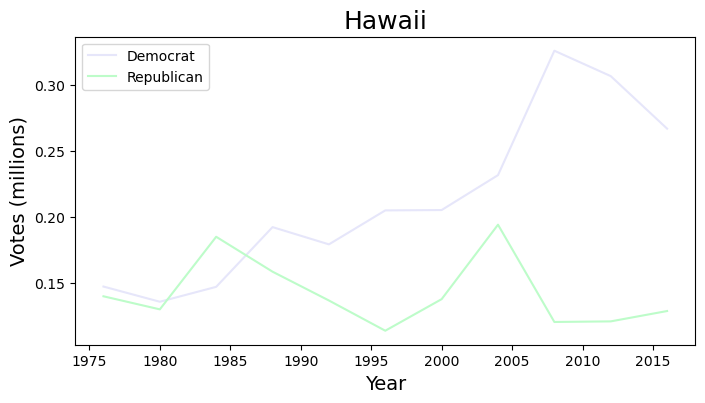

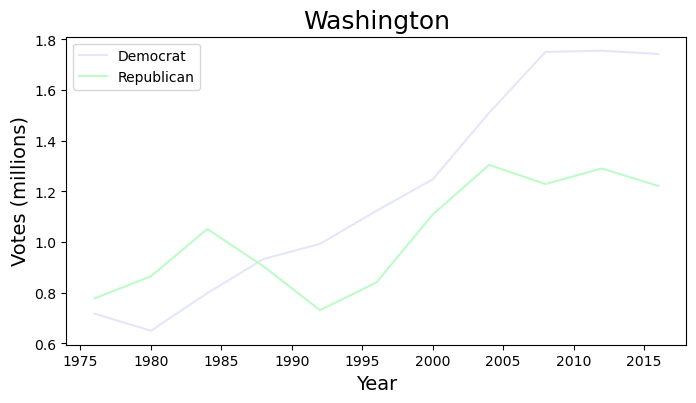

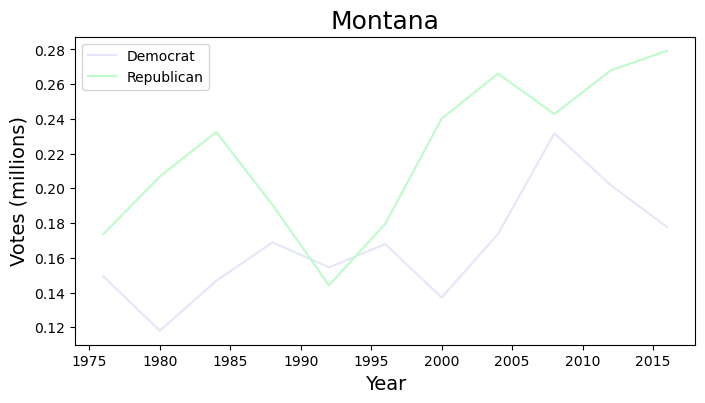

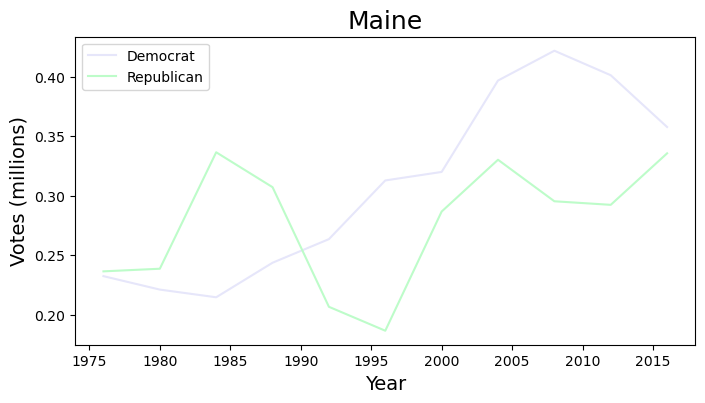

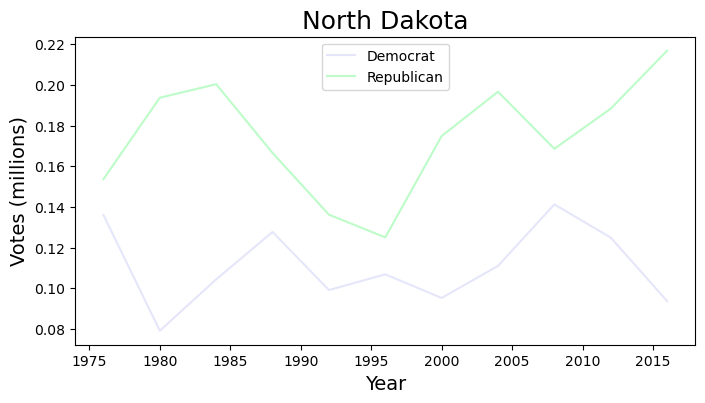

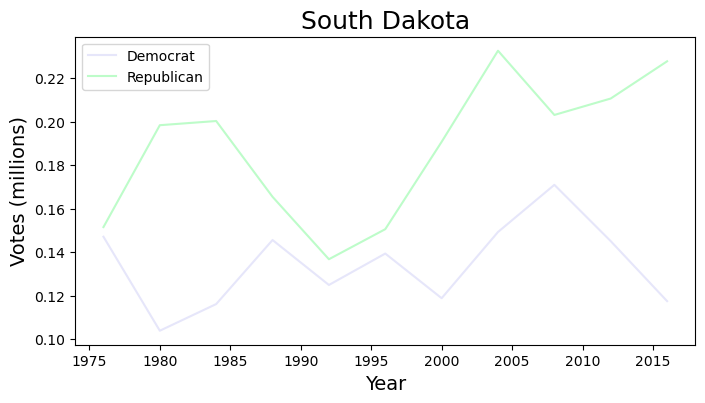

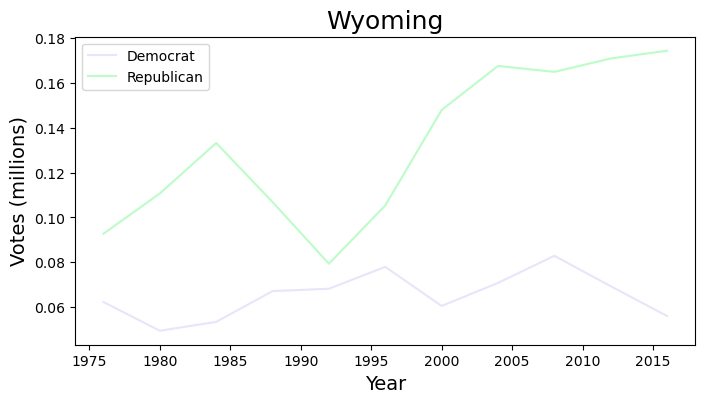

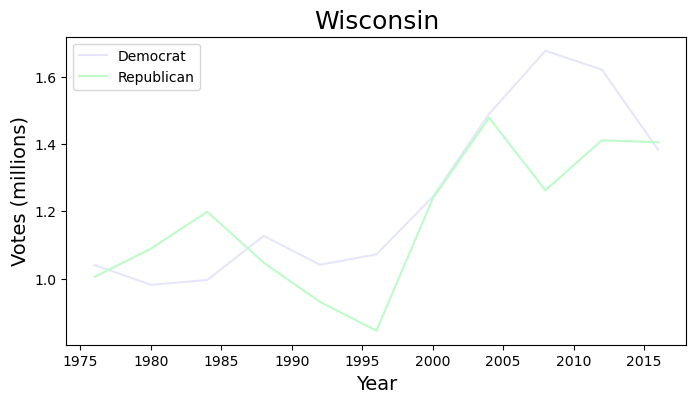

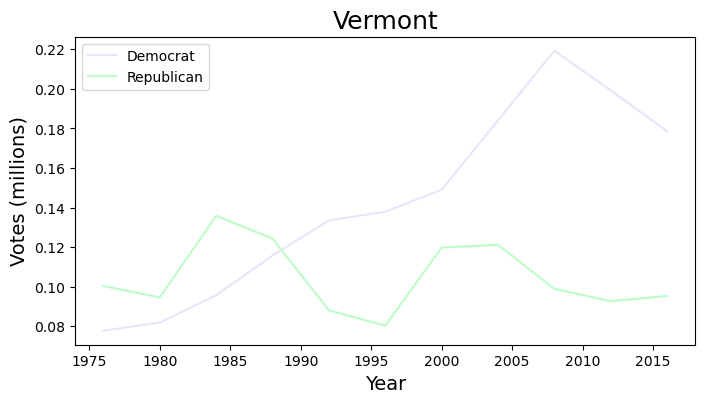

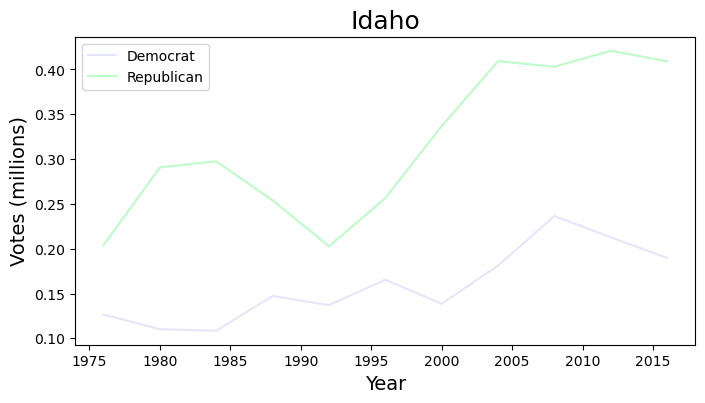

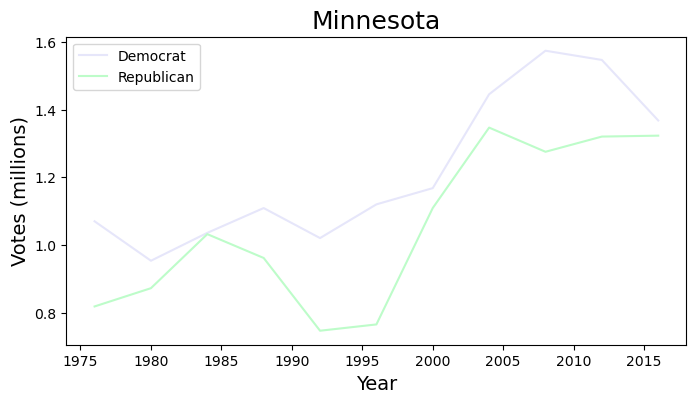

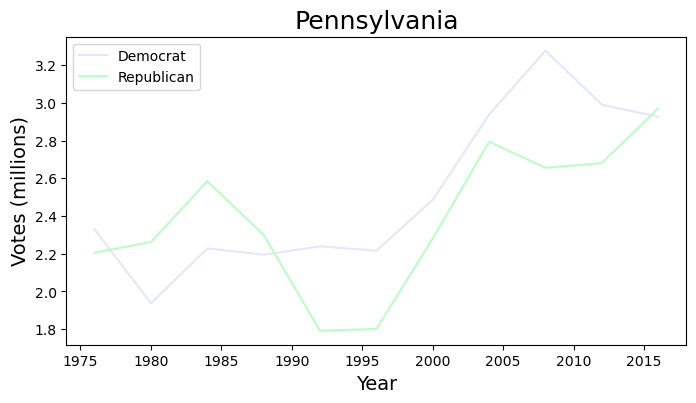

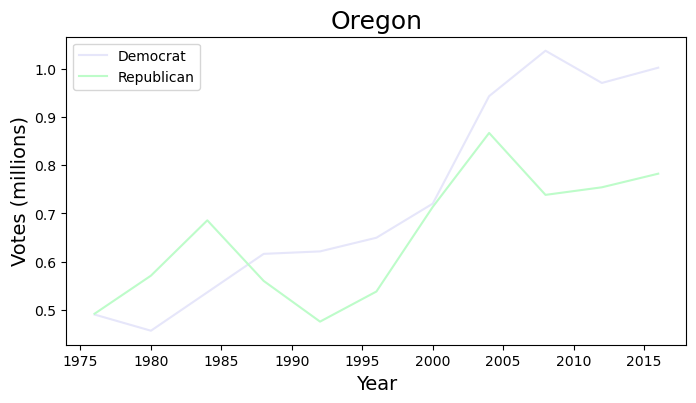

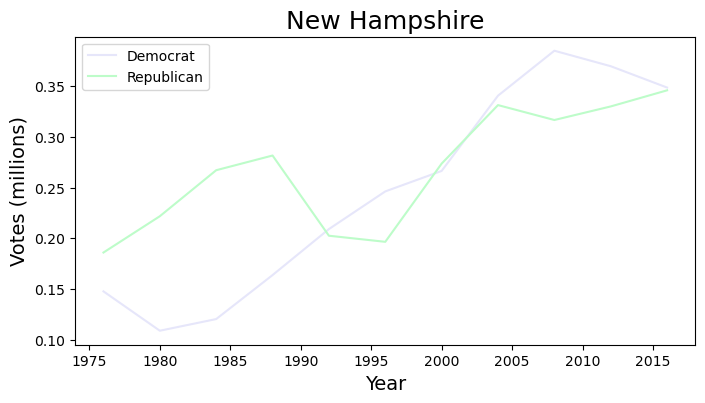

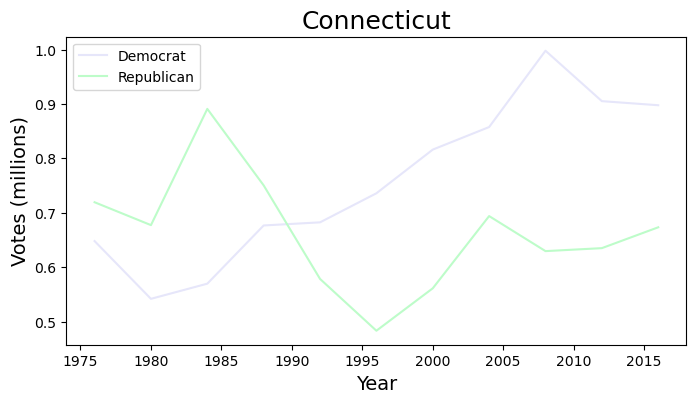

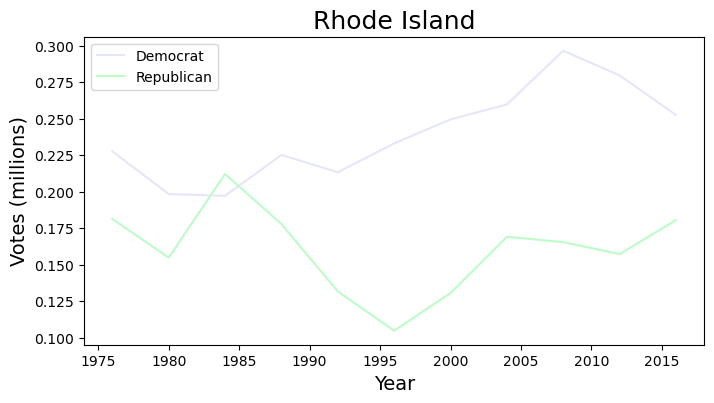

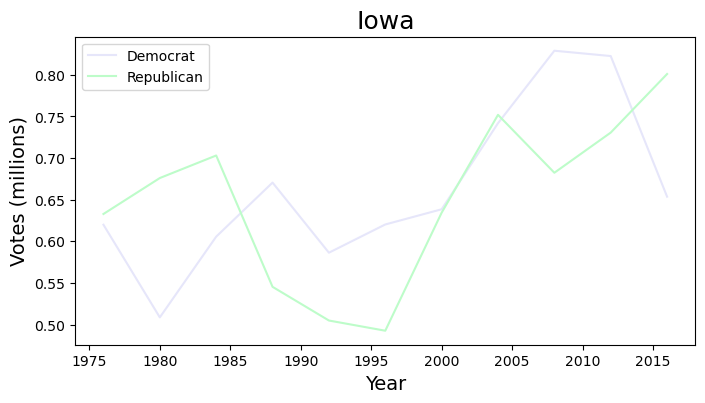

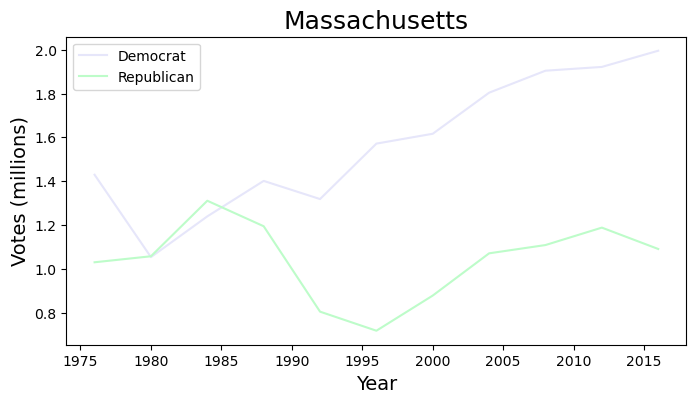

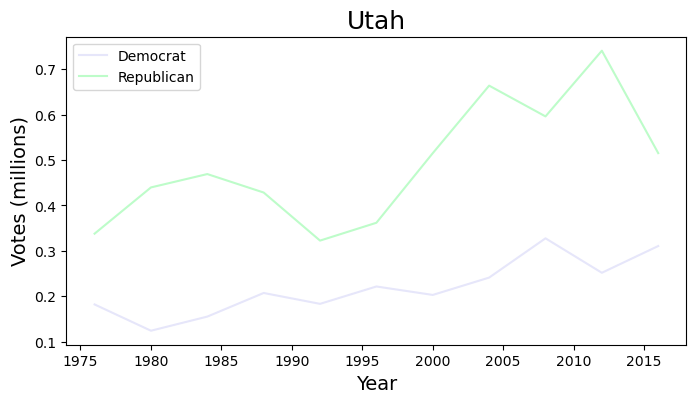

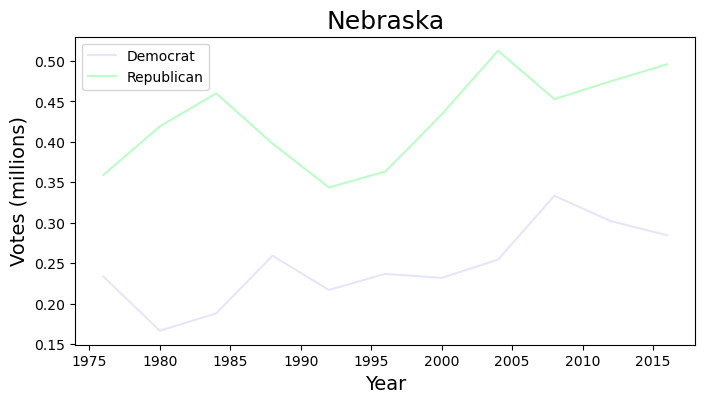

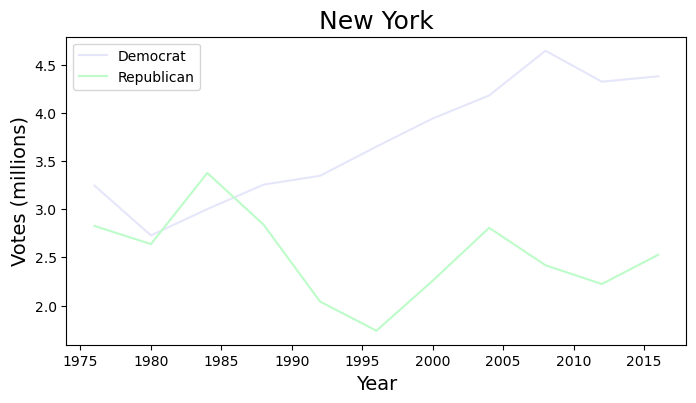

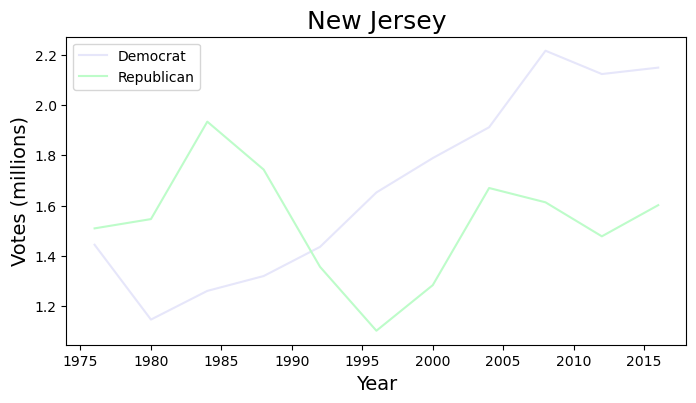

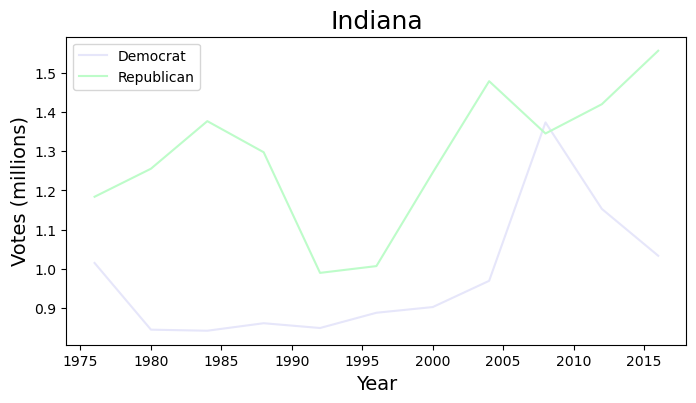

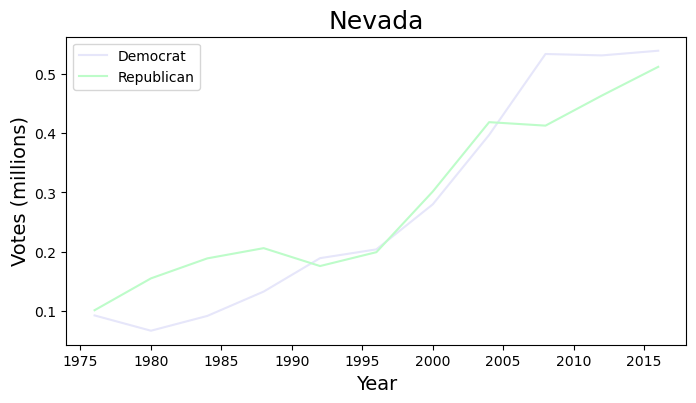

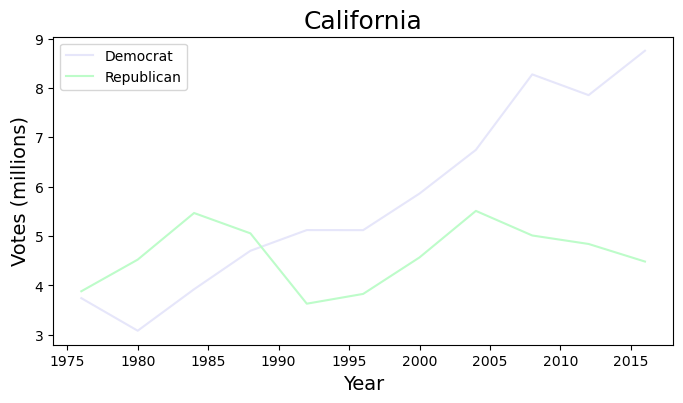

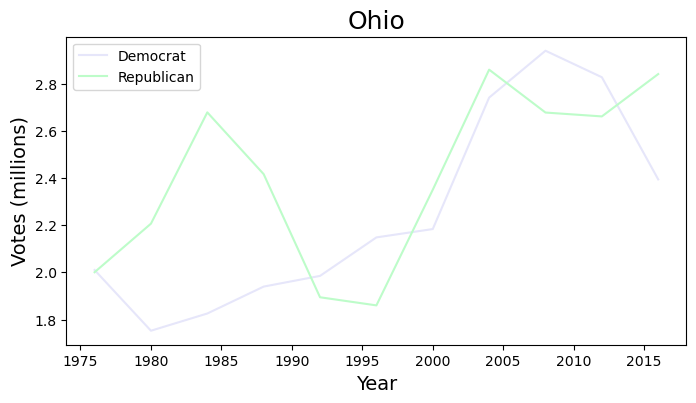

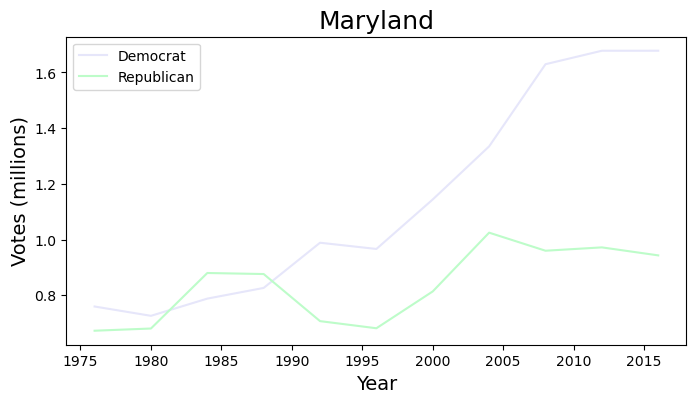

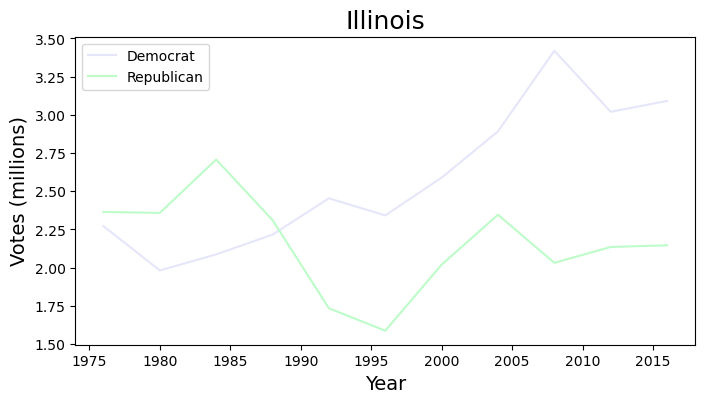

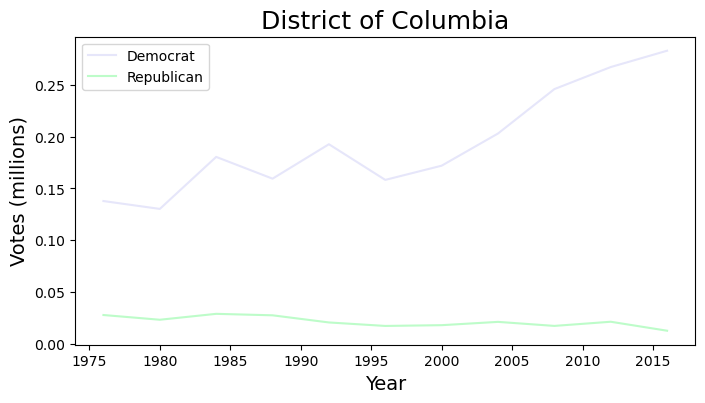

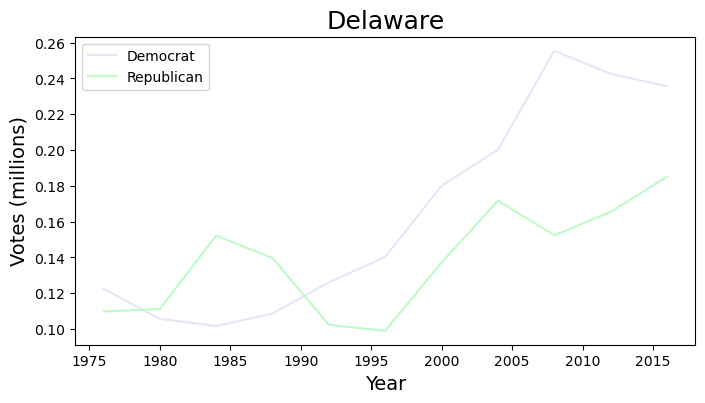

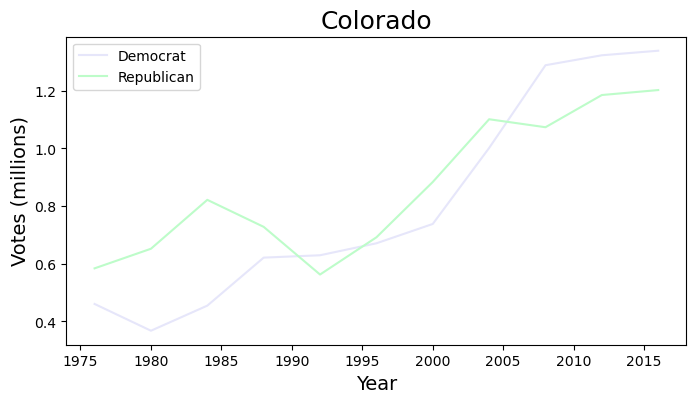

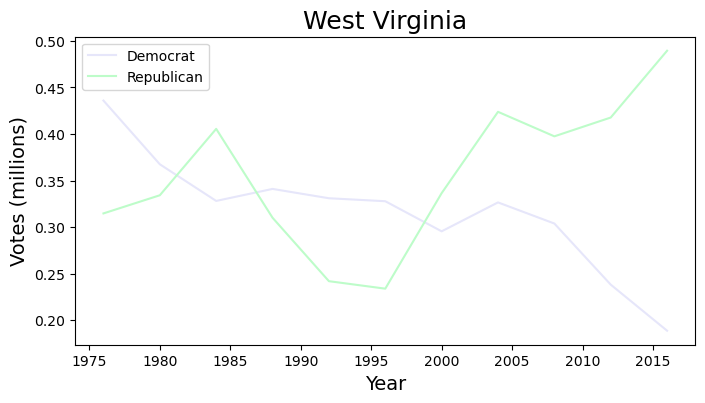

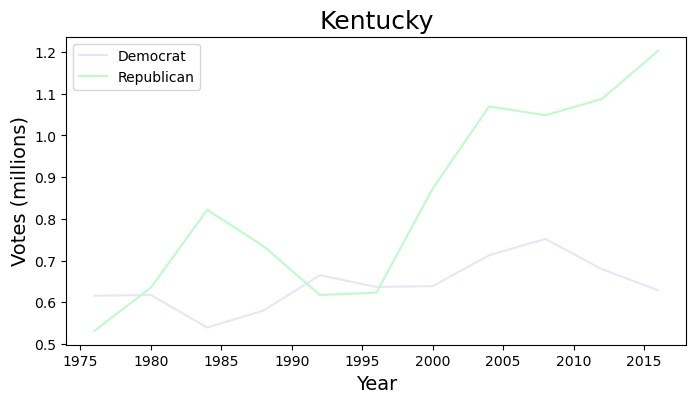

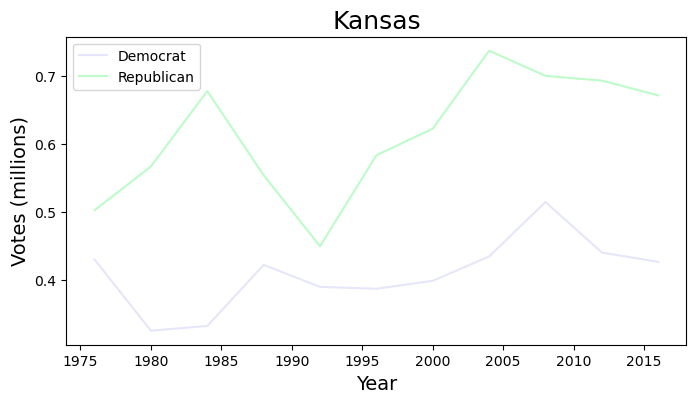

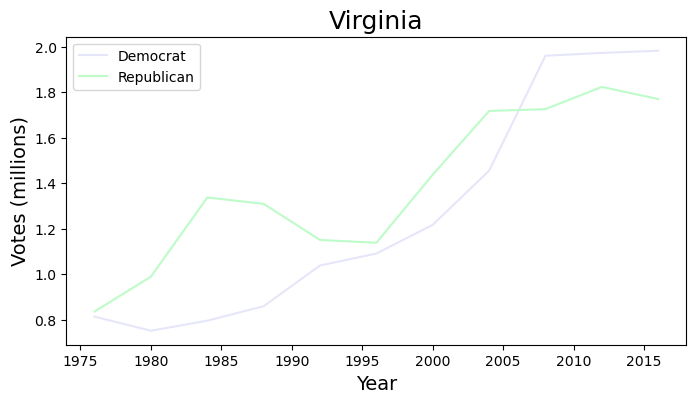

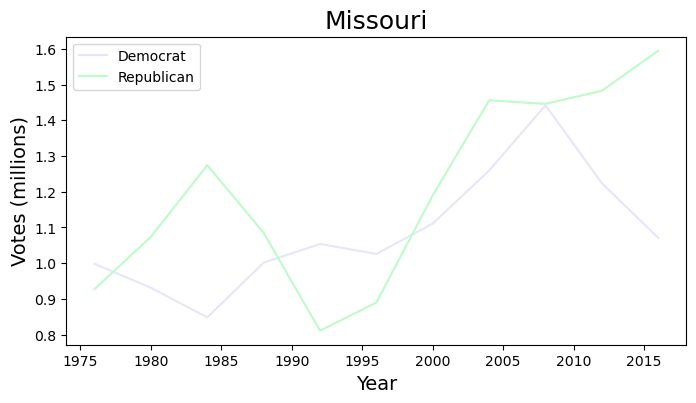

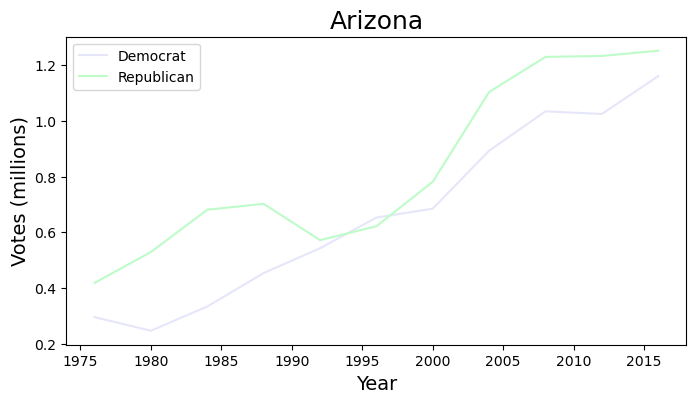

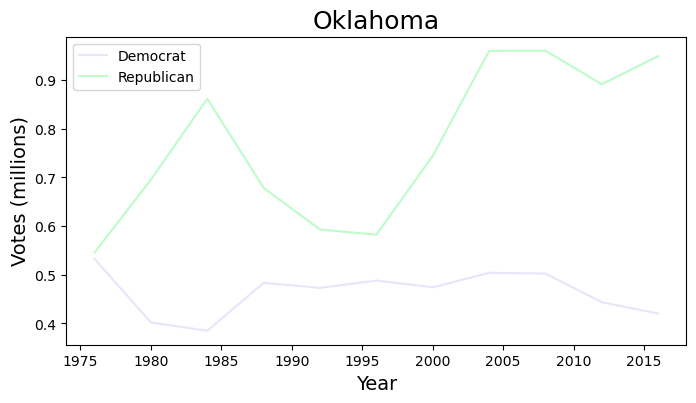

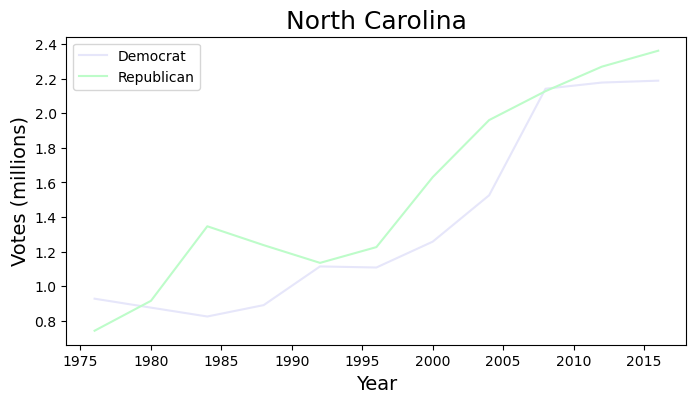

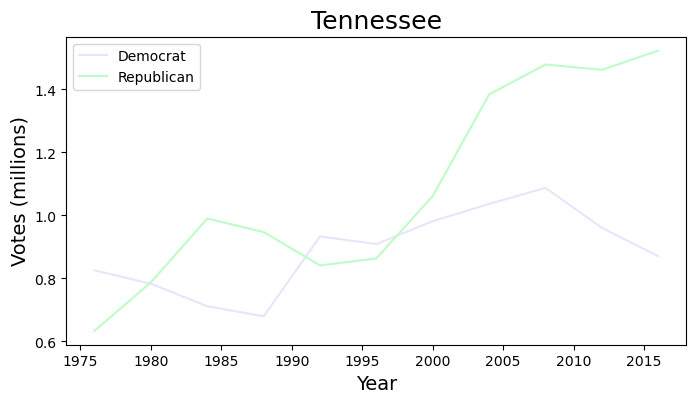

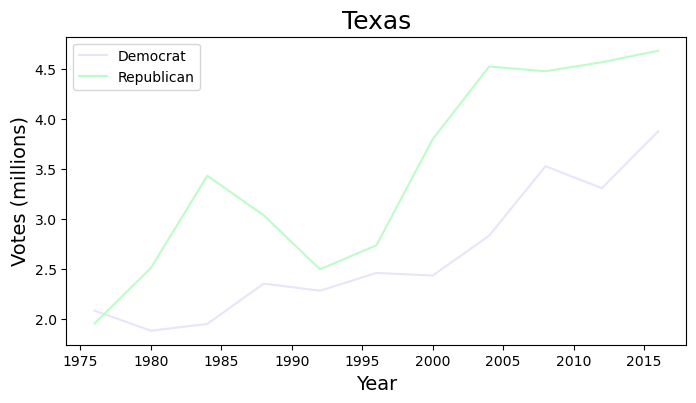

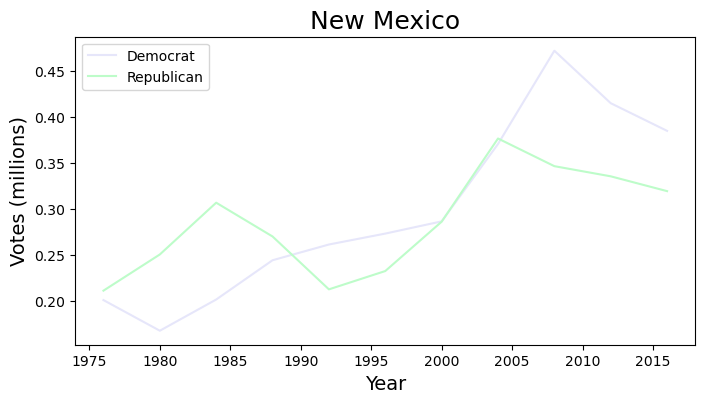

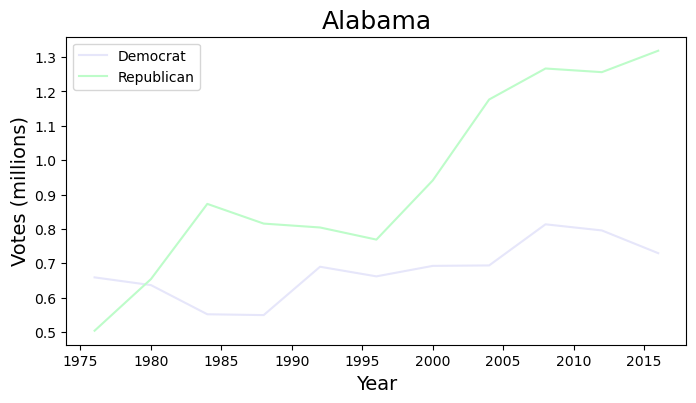

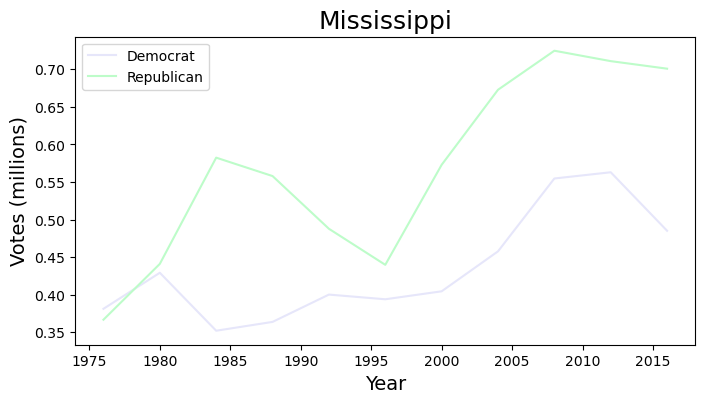

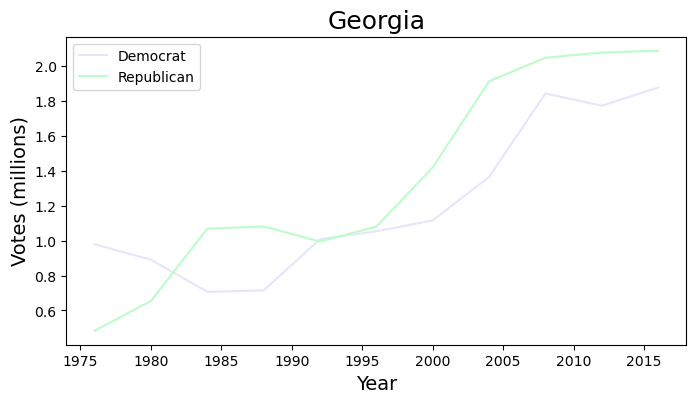

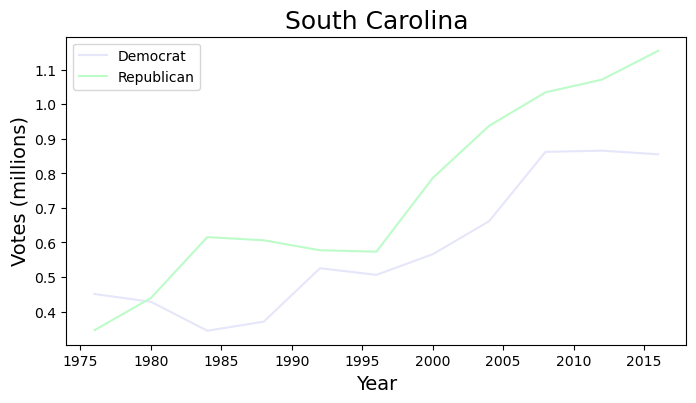

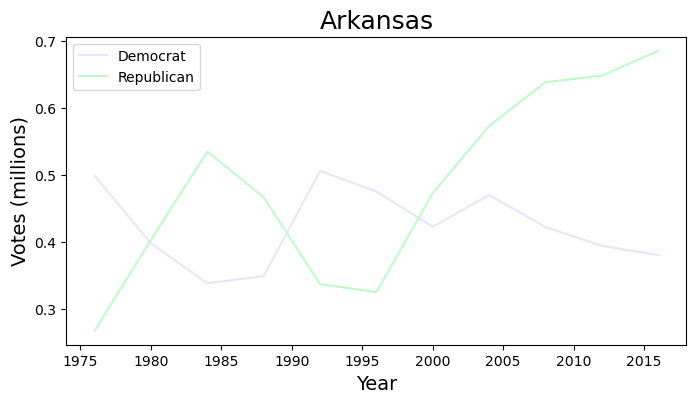

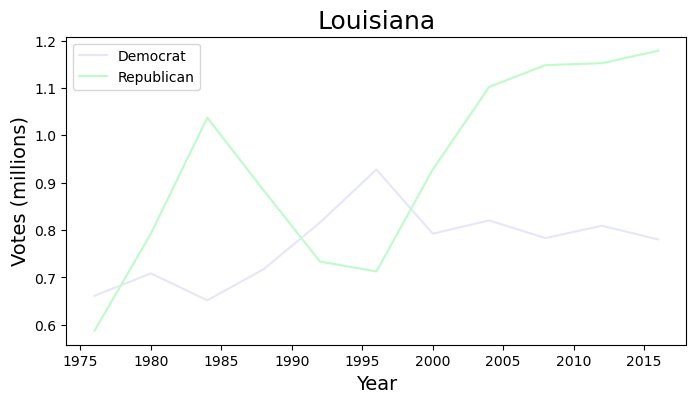

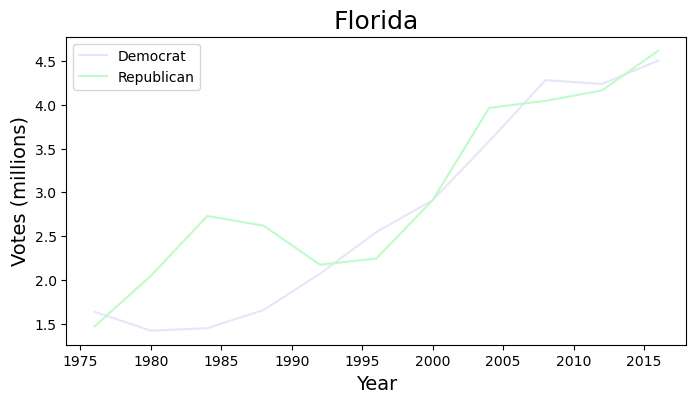

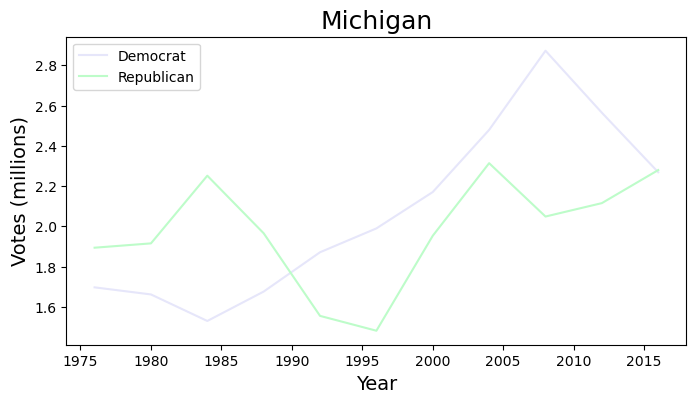

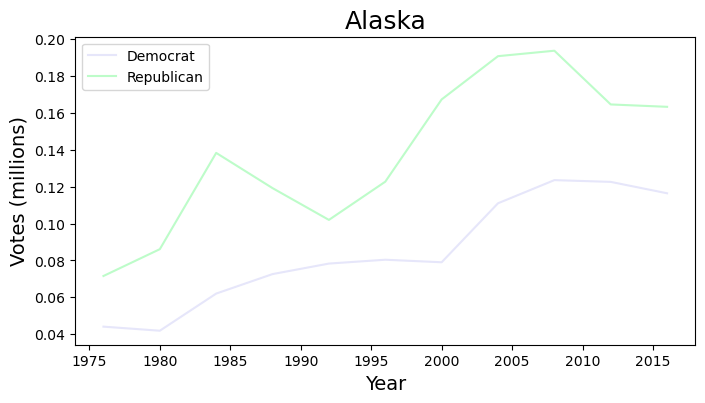

In [16]:
#plot choropleth button map
m = folium.Map(location=[50.77500, -100],zoom_start=3)
choropleth =folium.GeoJson(data= us_shape.to_json(),
                           style_function=style_function)
m.add_child(choropleth)

#Create popup button for each state
for i in range(len(us_shape)):
    
    geometry = us_shape.loc[i]['geometry']
    state_name = us_shape.loc[i]['state_name']
    popup = folium.Popup(getFigure(state_name),max_width=1000)
    
    state_marker = folium.GeoJson(data=mapping(geometry),
                                  highlight_function = highlight_style)
    state_marker.add_child(popup)
    m.add_child(state_marker)

#m.save("../figures/us_election_map2.html")